# Algoritmo de Gillespie aplicado al modelo SIR estocástico

**Objetivos:**
- Comprender el algoritmo de Gillespie (SSA) paso a paso.
- Implementar el modelo SIR de forma estocástica.
- Observar el impacto de $R_0$ en simulaciones individuales.
- Visualizar el umbral de inmunidad de grupo.

## 1. Introducción

El algoritmo de Gillespie (SSA) es un método de Monte Carlo para simular trayectorias individuales de sistemas de reacciones químicas o epidemiológicas en el régimen de pequeñas poblaciones, donde la aleatoriedad intrínseca es relevante.

En el modelo SIR estocástico:
- **Reacción de infección:** $S + I \xrightarrow{\beta} 2I$
- **Reacción de recuperación:** $I \xrightarrow{\gamma} R$

Cada evento ocurre de forma discreta y aleatoria, y el tiempo entre eventos sigue una distribución exponencial cuya tasa es la suma de todas las propensiones.

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 2. Definición de reacciones y funciones de propensión

In [37]:
def propensity(S, I, R, beta, gamma):
    """
    Calcula las propensiones de infección y recuperación.
    """
    N = S + I + R
    a_infect = beta * S * I / N
    a_recover = gamma * I
    return a_infect, a_recover

In [39]:
# Vectores de cambio (stoichiometry)
nu_infect = np.array([-1, +1, 0])  # S->S-1, I->I+1
nu_recover = np.array([0, -1, +1]) # I->I-1, R->R+1

## 3. Implementación del algoritmo de Gillespie (SSA)

In [42]:
def gillespie_sir(beta, gamma, S0, I0, R0, t_max):
    """
    Simula una trayectoria SIR estocástica con SSA hasta tiempo t_max.
    Retorna arrays de tiempos y poblaciones.
    """
    t = 0.0
    S, I, R = S0, I0, R0
    times = [t]
    traj = [[S, I, R]]
    while t < t_max and I > 0:
        a_inf, a_rec = propensity(S, I, R, beta, gamma)
        a0 = a_inf + a_rec
        if a0 <= 0:
            break
        tau = np.random.exponential(1.0 / a0)
        if np.random.rand() < a_inf / a0:
            # Evento de infección: un susceptible se contagia
            nu = nu_infect
        else:
            # Evento de recuperación: un infectado se recupera
            nu = nu_recover
        t += tau
        S, I, R = S + nu[0], I + nu[1], R + nu[2]
        times.append(t)
        traj.append([S, I, R])
    return np.array(times), np.array(traj)

### Ejemplo de simulación

Simulemos una trayectoria con parámetros de ejemplo:

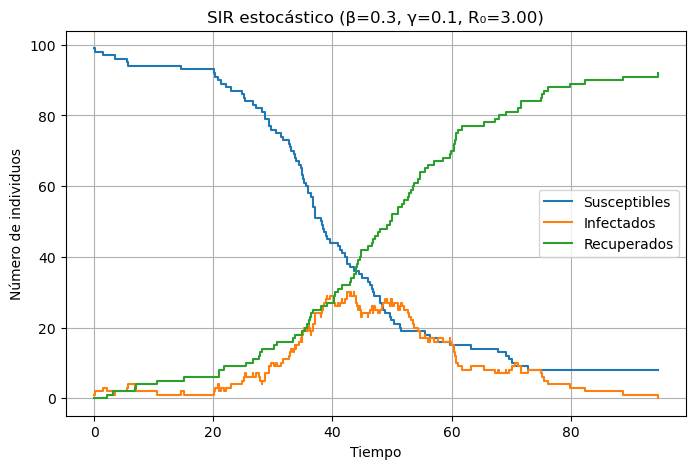

In [65]:
# Parámetros de ejemplo
beta = 0.3    # tasa de contagio
gamma = 0.1   # tasa de recuperación
S0, I0, R0 = 99, 1, 0
t_max = 160

t, traj = gillespie_sir(beta, gamma, S0, I0, R0, t_max)
S_vals, I_vals, R_vals = traj.T

plt.figure(figsize=(8,5))
plt.step(t, S_vals, where='post', label='Susceptibles')
plt.step(t, I_vals, where='post', label='Infectados')
plt.step(t, R_vals, where='post', label='Recuperados')
plt.xlabel('Tiempo')
plt.ylabel('Número de individuos')
plt.title(f'SIR estocástico (β={beta}, γ={gamma}, R₀={beta/gamma:.2f})')
plt.legend()
plt.grid(True)
plt.show()

## 4. Influencia de $R_0$

Comparación de simulaciones para $R_0<1$ y $R_0>1$:

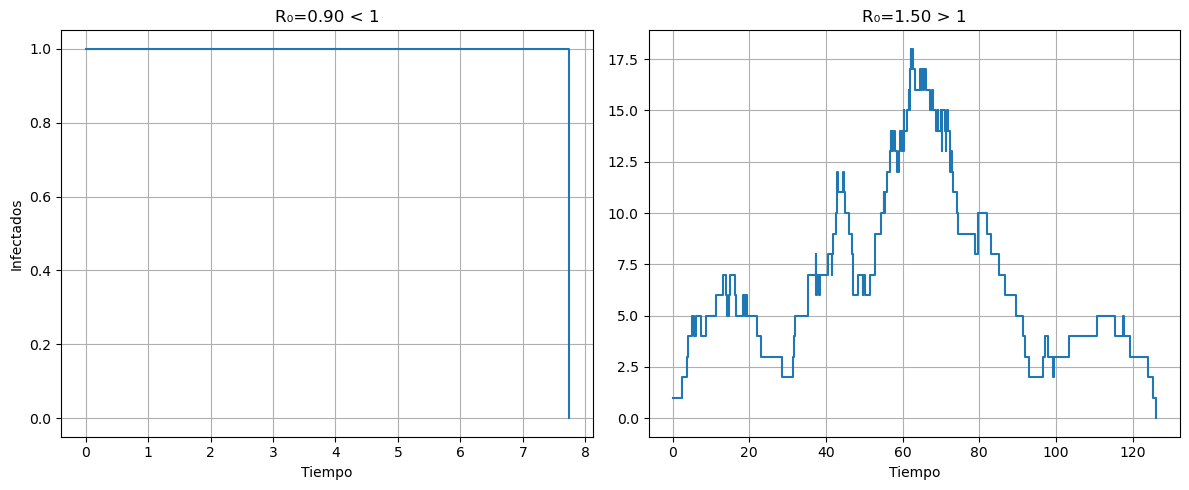

In [102]:
# Caso R0<1
beta1, gamma1 = 0.09, 0.1
t1, traj1 = gillespie_sir(beta1, gamma1, S0, I0, R0, t_max)
S1, I1, R1 = traj1.T

# Caso R0>1
beta2, gamma2 = 0.15, 0.1
t2, traj2 = gillespie_sir(beta2, gamma2, S0, I0, R0, t_max)
S2, I2, R2 = traj2.T

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.step(t1, I1, where='post')
plt.title(f'R₀={beta1/gamma1:.2f} < 1')
plt.xlabel('Tiempo')
plt.ylabel('Infectados')
plt.grid(True)
plt.subplot(1,2,2)
plt.step(t2, I2, where='post')
plt.title(f'R₀={beta2/gamma2:.2f} > 1')
plt.xlabel('Tiempo')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Umbral de inmunidad de grupo

Para $R_0>1$, el umbral es $p_c = 1 - 1/R_0$. Lo visualizamos sobre la fracción recuperada:

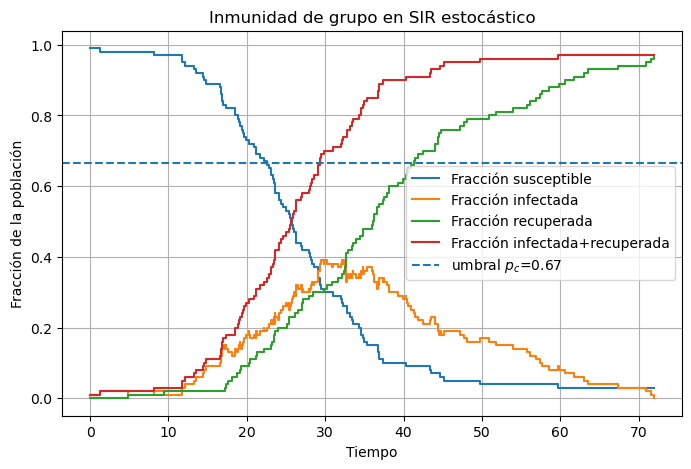

In [114]:
beta, gamma = 0.3, 0.1
R0_val = beta / gamma
p_c = 1 - 1 / R0_val
t_h, traj_h = gillespie_sir(beta, gamma, S0, I0, R0, t_max)
S_h, I_h, R_h = traj_h.T
frac_S = S_h / (S0 + I0 + R0)
frac_I = I_h / (S0 + I0 + R0)
frac_R = R_h / (S0 + I0 + R0)

plt.figure(figsize=(8,5))
plt.step(t_h, frac_S, where='post', label='Fracción susceptible')
plt.step(t_h, frac_I, where='post', label='Fracción infectada')
plt.step(t_h, frac_R, where='post', label='Fracción recuperada')
plt.step(t_h, frac_I+frac_R, where='post', label='Fracción infectada+recuperada')
plt.axhline(p_c, linestyle='--', label=f'umbral $p_c$={p_c:.2f}')
plt.xlabel('Tiempo')
plt.ylabel('Fracción de la población')
plt.title('Inmunidad de grupo en SIR estocástico')
plt.legend()
plt.grid(True)
plt.show()

----
Para modificar parámetros, edita las variables en las celdas de código y vuelve a ejecutar con **Shift+Enter**.